In [27]:
# Packages 
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import qmc
import glob
import h5py
import time
from datetime import timedelta

# We change the default level of the logger so that
# we can see what's happening with caching.
import sys, os
import logging
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c

# For interacting with the cache
from py21cmfast import cache_tools

# Parallize
import multiprocessing
from multiprocessing import Pool
try:
    from mpi4py import MPI
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
except ImportError:
    rank = 0
    size = 1

class Coevals():
    def __init__(self, params_ranges, num_images=9, **kwargs):
        """
        Generate dataset by 21cmFAST in parallel.
        Input: params_ranges = {'param1': [min, max], 'param2': [min, max], ...}
        Output: hdf5 storing images and params.
        """
        self.params_ranges = params_ranges
        self.num_images = num_images
        self.define_kwargs(kwargs)

        # print parameters information
        if rank == 0:
            self.print_kwargs_params()

        self.sample_normalized_params(dimension=len(self.params_ranges), num_images=num_images)
        self.denormalize()
        # self.define_default_params()


    def print_kwargs_params(self):
        print(f" Mission: Generate {self.num_images} images ".center(self.kwargs['str_pad_len'], '#'))#, self.kwargs['str_pad_type']))

        print(f"params:".center(int(self.kwargs['str_pad_len']/2),self.kwargs['str_pad_type'])+f"ranges:".center(int(self.kwargs['str_pad_len']/2),self.kwargs['str_pad_type']))
        for key in self.params_ranges:
            print(f"{key}".center(int(self.kwargs['str_pad_len']/2))+f"[{self.params_ranges[key][0]}, {self.params_ranges[key][-1]}]".center(int(self.kwargs['str_pad_len']/2)))
        # print(f"params_ranges = {self.params_ranges}".center(self.kwargs['str_pad_len'], self.kwargs['str_pad_type']))
        
        if self.kwargs['verbose'] >= 0.5:
            # print(f"**kwargs will be passed to qmc.LatinHypercube".center(self.kwargs['str_pad_len'], self.kwargs['str_pad_type']))
            print(f"kwargs:".center(int(self.kwargs['str_pad_len']/2), self.kwargs['str_pad_type'])+f"values:".center(int(self.kwargs['str_pad_len']/2),self.kwargs['str_pad_type']))
            
            for key in self.kwargs:
                print(f"{key}".center(int(self.kwargs['str_pad_len']/2))+f"{self.kwargs[key]}".center(int(self.kwargs['str_pad_len']/2)))


    def define_kwargs(self, kwargs):
        self.kwargs = dict(
            # local params for Coevals.__init__()
            fields = ['brightness_temp', 'hires_density'],
            verbose = 1,
            seed = None,
            cache_direc = "/storage/home/hcoda1/3/bxia34/scratch/_cache",
            str_pad_len = 80,
            str_pad_type = '-',

            # strength param of scipy.stats.qmc.LatinHypercube():
            strength = 1,
            
            # redshift param of py21cmfast.run_coeval():
            redshift = [8,9,10],
            
            # user_params of py21cmfast.run_coeval():
            HII_DIM = 60, 
            BOX_LEN = 150,
            USE_INTERPOLATION_TABLES = True,
            
            # cosmo_params of py21cmfast.run_coeval():
            SIGMA_8 = 0.810,
            hlittle = 0.677,
            OMm = 0.310,
            OMb = 0.0490,
            POWER_INDEX = 0.967,
        )

        # update
        for key in kwargs:
            self.kwargs[key] = kwargs[key]

        if not os.path.exists(self.kwargs['cache_direc']):
            os.mkdir(self.kwargs['cache_direc'])
        p21c.config['direc'] = self.kwargs['cache_direc']

    def sample_normalized_params(self, dimension, num_images):
        """
        sample and scatter to other nodes
        """
        if rank == 0:
            np.random.seed(self.kwargs['seed'])
            sampler = qmc.LatinHypercube(d=dimension, strength=self.kwargs['strength'], seed=np.random.default_rng(self.kwargs['seed']))
            sample = sampler.random(n=num_images)
            send_data = sample[:int(sample.shape[0]//size * size),:]
            send_data = send_data.reshape(size, int(send_data.shape[0]/size), send_data.shape[1])
            print(f"Process {rank} scatters data {sample.shape} to {size} nodes".center(self.kwargs['str_pad_len'],self.kwargs['str_pad_type']))
        else:
            send_data = None
        self.recv_data = comm.scatter(send_data, root=0)
        print(f"Process {rank} recvs data {self.recv_data.shape}".center(self.kwargs['str_pad_len']))#, self.kwargs['str_pad_type']))


    def denormalize(self):
        """
        denormalize data received, and return self.params_node which stores params for each node.
        """
        self.params_node = {}
        for i, kind in enumerate(self.params_ranges):
            x = self.recv_data.T[i]
            k = self.params_ranges[kind][-1]-self.params_ranges[kind][0]
            b = self.params_ranges[kind][0]
            self.params_node[kind] = k*x + b
            # print(np.shape(x))
            # print(np.shape(k))
            # print(np.shape(b))
            # print(len(self.params_node[kind]))


    # def define_default_params(self):
    #     self.redshift = 11.93 
    #     self.user_params = {
    #         "HII_DIM":60, 
    #         "BOX_LEN":150, 
    #         "USE_INTERPOLATION_TABLE":True
    #         }
    #     self.cosmo_params = dict(
    #         SIGMA_8 = 0.810,
    #         hlittle = 0.677,
    #         OMm = 0.310,
    #         OMb = 0.0490,
    #         POWER_INDEX = 0.967,
    #         )
    #     self.astro_params = dict(
    #         ION_Tvir_MIN = 5,#params['ION_Tvir_MIN'],
    #         HII_EFF_FACTOR = 100,#params['HII_EFF_FACTOR'],
    #         )


    # def update_params(self):
    #     params_dict_list = ["user_params", "cosmo_params", "astro_params"]
    #     params_type_list = ['kwargs', 'params_cpu']
    #     for params_dict in params_dict_list:
    #         for params_type in params_type_list:
    #             for key in self.__dict__[params_type]:
    #                 if key in self.__dict__[params_dict]:
    #                     self.__dict__[params_dict][key] = self.__dict__[params_type][key]

            # for key in self.params_cpu:
            #     if key in self.__dict__[params]:
            #         self.__dict__[params][key] = self.params_cpu[key]


    def run_coeval(self, params_node_value):
        # All parameters
        run_coeval_start = time.perf_counter()

        pid_cpu = multiprocessing.current_process().pid
        random_seed = int(params_node_value[-1])

        self.params_cpu = {key: params_node_value[i] for (i, key) in enumerate(self.params_node.keys())}
        # self.update_params()

        # concantenate and update parameters
        self.params_cpu = self.kwargs | self.params_cpu

        # Simulation
        coevals_cpu = p21c.run_coeval(
            redshift = self.params_cpu['redshift'],
            user_params = self.params_cpu,
            cosmo_params = p21c.CosmoParams(self.params_cpu),
            astro_params = p21c.AstroParams(self.params_cpu),
            random_seed = random_seed
        )

        dict_cpu = self.coevals2dict(coevals_cpu)

        cache_pattern = os.path.join(self.kwargs['cache_direc'], f"*{random_seed}*")
        for filename in glob.glob(cache_pattern):
            # print(filename)
            os.remove(filename)

        run_coeval_end = time.perf_counter()
        time_elapsed = run_coeval_end - run_coeval_start
        if self.kwargs['verbose'] == 1:
            print(f'cpu {pid_cpu} in {self.pid_node}, seed {random_seed}, {self.params_cpu}, cost {timedelta(seconds=time_elapsed)}')

        return dict_cpu

    def coevals2dict(self, coevals_cpu):
        images_cpu = {}
        for i, field in enumerate(self.kwargs['fields']):
            images_cpu[field] = []
            for j, coeval in enumerate(coevals_cpu):
                images_cpu[field].append(coeval.__dict__[field])
        # print(images_cpu.keys())
        # print(images_cpu.values())
        return images_cpu
            # save images, params as .h5 file
            # self.save(images_node, params=np.array(list(self.params_node.values())).T, save_direc_name=save_direc_name)

    # def coevals2images(self, coevals_node):
    #     images_node = {}
    #     for i, field in enumerate(self.kwargs['fields']):
    #         images_node[field] = []
    #         for coevals_cpu in coevals_node:
    #             # coevals_cpu corresponds to 1 params_cpu
    #             for j, coeval in enumerate(coevals_cpu):
    #                 images_node[field].append(coeval.__dict__[field])
    #         # save images, params as .h5 file
    #         self.save(images_node, params=np.array(list(self.params_node.values())).T, save_direc_name=save_direc_name)

    def run(self, save_direc_name='images_params.h5'):
        self.pid_node = os.getpid()
        self.CPU_num = len(os.sched_getaffinity(self.pid_node))
        
        print(f"node {self.pid_node}: {self.CPU_num} CPUs are working on {np.shape(list(self.params_node.values()))[-1]} groups of params".center(self.kwargs['str_pad_len'],self.kwargs['str_pad_type']))

        # run p21c.run_coeval in parallel on multi-CPUs
        Pool_start = time.perf_counter()

        with Pool(self.CPU_num) as p:
            self.random_seed = np.random.randint(1,2**32, size = self.num_images)
            iterable = np.array(list(self.params_node.values()))
            iterable = np.vstack((iterable, self.random_seed)).T
            # print(iterable)
            # images_node = np.array(p.map(self.run_coeval, iterable))
            dict_node = p.map(self.run_coeval, iterable)
        
        images_node = self.dict2images(dict_node)

        Pool_end = time.perf_counter()
        time_elapsed = Pool_end - Pool_start

        # save images, params as .h5 file
        self.save(images_node, params=np.array(list(self.params_node.values())).T, save_direc_name=save_direc_name)

        print(f"node {self.pid_node}: {self.images_node_nbytes/1024**2:.2f} MB images {[np.shape(images) for images in images_node.values()]} saved to {save_direc_name}, cost {timedelta(seconds=int(time_elapsed))}".center(self.kwargs['str_pad_len'],self.kwargs['str_pad_type']))

        return images_node

    def dict2images(self, dict_node):
        images_node = {}
        for field in self.kwargs['fields']:
            images_node[field] = []
            for dict_cpu in dict_node:
                images_node[field].append(dict_cpu[field])
        return images_node

    # Save as hdf5
    def save(self, images_node, params, save_direc_name):
        # if os.path.exists(save_direc_name):
        #     os.remove(save_direc_name)
        # HII_DIM = images.shape[-1]
        self.images_node_nbytes = 0
        with h5py.File(save_direc_name, 'a') as f:
            if 'kwargs' not in f.keys():
                grp = f.create_group('kwargs')
                grp['keys'] = list(self.kwargs)
                grp['values'] = [str(value) for value in self.kwargs.values()]

            if 'params' not in f.keys():
                grp = f.create_group('params')
                grp['keys'] = list(self.params_ranges)
                grp.create_dataset(
                    'values',
                    data = params,
                    maxshape = tuple((None,) + params.shape[1:]),
                    )
            else:
                new_size = f['params']['values'].shape[0] + params.shape[0]
                f['params']['values'].resize(new_size, axis=0)
                f['params']['values'][-params.shape[0]:] = params

            for field in self.kwargs['fields']:
                images = np.array(images_node[field])
                # self.images_node.append(images)
                # print(np.shape(images))
                self.images_node_nbytes += images.nbytes
                if field not in f.keys():
                    f.create_dataset(
                        field, 
                        data=images, 
                        maxshape= tuple((None,) + images.shape[1:])
                    )
                    # f.create_dataset(
                    #     'random_seed',
                    #     data=random_seed,
                    #     maxshape=(None,1)
                    # )
                else:
                    # print(image.shape)
                    new_size = f[field].shape[0] + images.shape[0]
                    f[field].resize(new_size, axis=0)
                    f[field][-images.shape[0]:] = images
                    # f['random_seed'].resize(new_size, axis=0)
                    # f['random_seed'][-1] = random_seed

In [28]:
if __name__ == '__main__':
    # training set, (25600, 64, 64, 64)
    params_ranges = dict(
        ION_Tvir_MIN = [4,6],#params['ION_Tvir_MIN'],
        HII_EFF_FACTOR = [10, 250],#params['HII_EFF_FACTOR']
        )
    generator = Coevals(params_ranges, num_images=8, strength=1, HII_DIM=30, BOX_LEN=45, verbose=0.5, redshift=[8,9,10])
    generator.run(save_direc_name="train.h5")

    # testing set, (5*800, 64, 64, 64)
    params_list = \
        [(4.4,131.341),(5.6,19.037), (4.699,30), (5.477,200), (4.8,131.341)]
    for T_vir, zeta in params_list:
        params_ranges = dict(
        ION_Tvir_MIN = [T_vir],#params['ION_Tvir_MIN'],
        HII_EFF_FACTOR = [zeta],#params['HII_EFF_FACTOR']
        )
        generator = Coevals(params_ranges, num_images=2, verbose=0.5)
        generator.run(save_direc_name="test.h5")

########################## Mission: Generate 8 images ##########################
----------------params:---------------------------------ranges:-----------------
              ION_Tvir_MIN                               [4, 6]                 
             HII_EFF_FACTOR                            [10, 250]                
----------------kwargs:---------------------------------values:-----------------
                 fields                   ['brightness_temp', 'hires_density']  
                verbose                                   0.5                   
                  seed                                    None                  
              cache_direc               /storage/home/hcoda1/3/bxia34/scratch/_cache
              str_pad_len                                  80                   
              str_pad_type                                 -                    
                strength                                   1                    
                redshift

In [21]:
# !rm t.h5
import h5py
with h5py.File("train.h5", 'r') as f:
    # grp = f.create_group("kwargs")
    print(f.keys())
    print(f['brightness_temp'])
    images = np.array(f['brightness_temp'])
    print(f['hires_density'])
    print(f['kwargs'])
    print(f['params'])
    print(f['kwargs'].keys())
    print(f['params'].keys())
    print(f['kwargs']['keys'])
    print(f['kwargs']['values'])
    print(f['params']['keys'])
    print(f['params']['values'])

<KeysViewHDF5 ['brightness_temp', 'hires_density', 'kwargs', 'params']>
<HDF5 dataset "brightness_temp": shape (24, 3, 30, 30, 30), type "<f4">
<HDF5 dataset "hires_density": shape (24, 3, 90, 90, 90), type "<f4">
<HDF5 group "/kwargs" (2 members)>
<HDF5 group "/params" (2 members)>
<KeysViewHDF5 ['keys', 'values']>
<KeysViewHDF5 ['keys', 'values']>
<HDF5 dataset "keys": shape (16,), type "|O">
<HDF5 dataset "values": shape (16,), type "|O">
<HDF5 dataset "keys": shape (2,), type "|O">
<HDF5 dataset "values": shape (24, 2), type "<f8">


In [23]:
# !rm t.h5
import h5py
with h5py.File("test.h5", 'r') as f:
    # grp = f.create_group("kwargs")
    print(f.keys())
    print(f['brightness_temp'])
    images = np.array(f['brightness_temp'])
    print(f['hires_density'])
    print(f['kwargs'])
    print(f['params'])
    print(f['kwargs'].keys())
    print(f['params'].keys())
    print(list(f['kwargs']['keys']))
    print(f['kwargs']['values'])
    print(list(f['params']['keys']))
    print(f['params']['values'])

<KeysViewHDF5 ['brightness_temp', 'hires_density', 'kwargs', 'params']>
<HDF5 dataset "brightness_temp": shape (10, 3, 60, 60, 60), type "<f4">
<HDF5 dataset "hires_density": shape (10, 3, 180, 180, 180), type "<f4">
<HDF5 group "/kwargs" (2 members)>
<HDF5 group "/params" (2 members)>
<KeysViewHDF5 ['keys', 'values']>
<KeysViewHDF5 ['keys', 'values']>
[b'fields', b'verbose', b'seed', b'cache_direc', b'str_pad_len', b'str_pad_type', b'strength', b'redshift', b'HII_DIM', b'BOX_LEN', b'USE_INTERPOLATION_TABLES', b'SIGMA_8', b'hlittle', b'OMm', b'OMb', b'POWER_INDEX']
<HDF5 dataset "values": shape (16,), type "|O">
[b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
<HDF5 dataset "values": shape (10, 2), type "<f8">


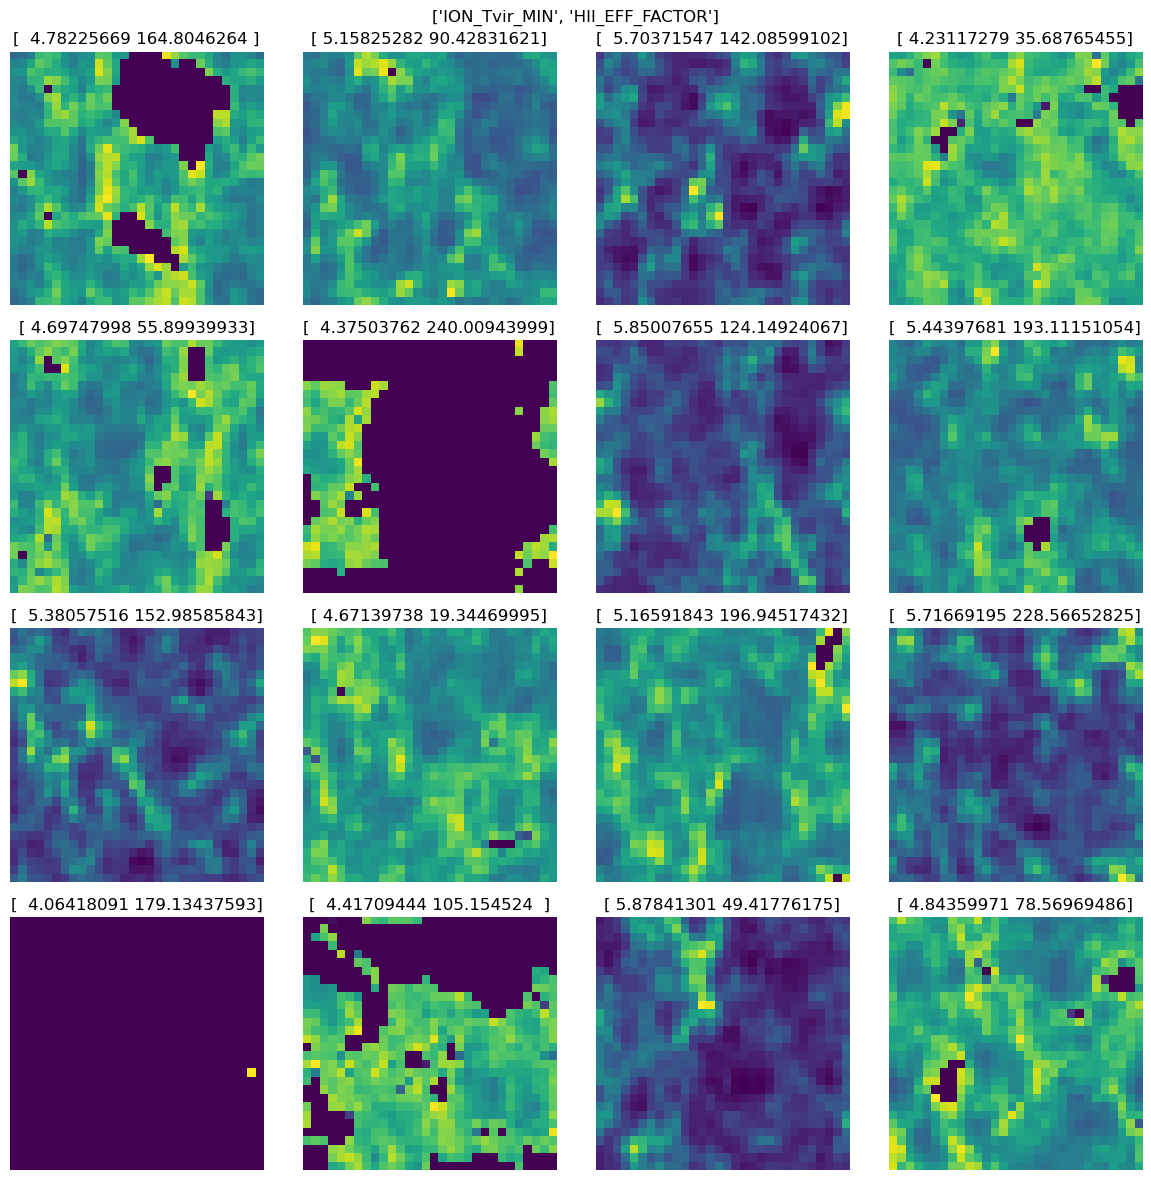

In [25]:
if __name__ == '__main__':
    fig, axes = plt.subplots(4,4, figsize=(12,12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(train_images[i][0])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.axis('off')
        ax.set_title(train_labels[i])
    # plt.margins(x=0, y=0)
    plt.suptitle(list(params_ranges.keys()))
    plt.tight_layout(w_pad=0.2)
    # plt.close()

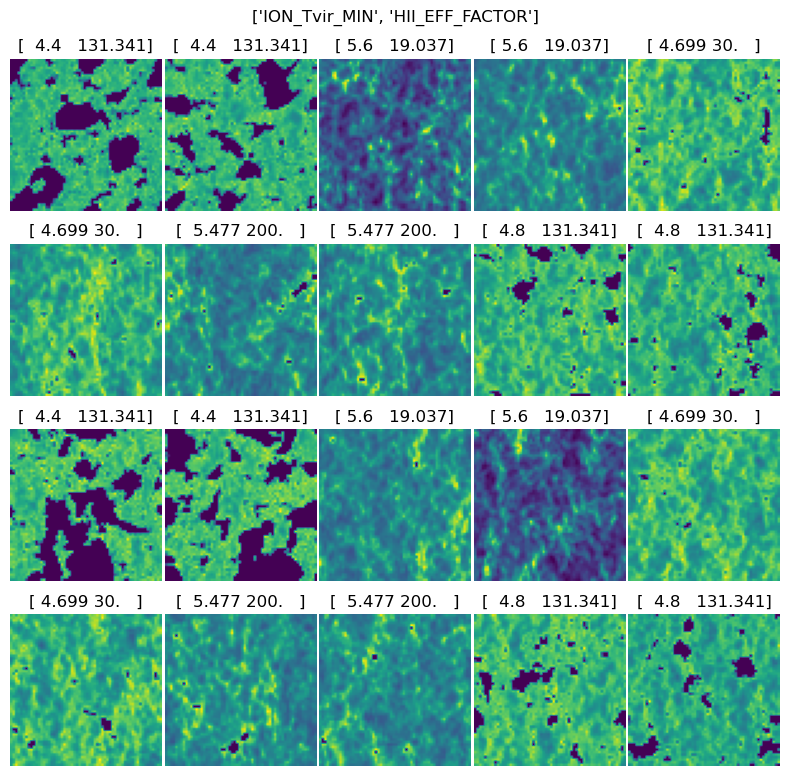

In [28]:
if __name__ == '__main__':
    fig, axes = plt.subplots(4,5, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(test_images[i][0])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.axis('off')
        ax.set_title(test_labels[i])
    # plt.margins(x=0, y=0)
    plt.suptitle(list(params_ranges.keys()))
    plt.tight_layout(w_pad=0.2)
    # plt.close()